In [1]:
import os
myfile = open("path.txt",mode="r")

datapath,repopath = myfile.readlines()
datapath = datapath.strip("\n")

In [2]:
path = os.getcwd()
if path.endswith('TFM') == True:
    !mkdir smote_reports
else:
    print("Ensure that you are in the /TFM folder")

Ya existe el subdirectorio o el archivo smote_reports.


#### Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import modules
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load data

In [4]:
# load the accidents_clean_csv file as a dataframe
df_imbalanced = pd.read_csv(datapath+"alldfjoined.csv",delimiter=',',encoding='UTF-8-SIG',index_col=0)

In [5]:
#Drop useless columns
df_imbalanced.drop(columns=['Acc_Index', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Date',
       'Road_Type','Month', 'Year', 'Hour','Speed_limit_2', 'Sex_of_Casualty',
       'Age_Band_of_Casualty', 'Casualty_Type','1st_Road_Class'],inplace=True)

In [6]:
df_imbalanced.columns

Index(['Vehicle_Type', 'Sex_of_Driver', 'Age_Band_of_Driver',
       'Engine_Capacity_(CC)', 'Age_of_Vehicle', 'Accident_Severity',
       'Day_of_Week', 'Speed_limit', 'Daytime', 'Road_Surface_Conditions_2',
       'Weather_Conditions_2', 'Light_Conditions_2'],
      dtype='object')

In [7]:
df_imbalanced.head(5)

,Vehicle_Type,Sex_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Age_of_Vehicle,Accident_Severity,Day_of_Week,Speed_limit,Daytime,Road_Surface_Conditions_2,Weather_Conditions_2,Light_Conditions_2
0,Motorcycle,Male,26 - 35,99,9,Slight,Wednesday,30,Office hours,Good,Good,Good
1,Motorcycle,Male,26 - 35,249,7,Slight,Friday,30,Office hours,Good,Good,Good
2,Goods vehicle over 3.5 tonnes,Male,46 - 55,3858,8,Slight,Friday,30,Office hours,Good,Good,Good
3,Motorcycle,Male,26 - 35,392,10,Slight,Wednesday,30,Commuting to home,Good,Good,Good
4,Motorcycle,Male,36 - 45,1000,5,Slight,Tuesday,30,Office hours,Good,Good,Good


In [8]:
df_imbalanced = modules.cat_num(df_imbalanced)

In [9]:
df_imbalanced.dtypes

Vehicle_Type                 category
Sex_of_Driver                category
Age_Band_of_Driver           category
Engine_Capacity_(CC)            int64
Age_of_Vehicle                  int64
Accident_Severity            category
Day_of_Week                  category
Speed_limit                  category
Daytime                      category
Road_Surface_Conditions_2    category
Weather_Conditions_2         category
Light_Conditions_2           category
dtype: object

### *Feature engineering*

#### *Processing numerical variables*

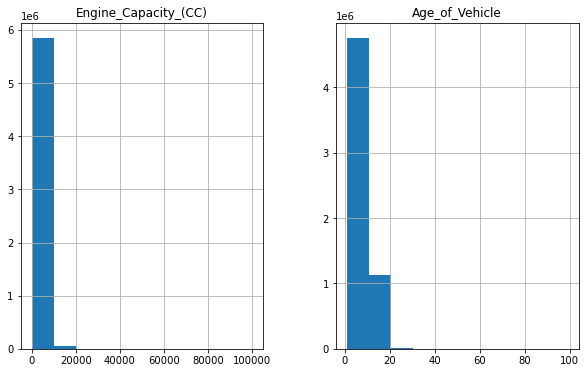

In [10]:
df_imbalanced.hist(figsize=(10,6));
#the two numerical variables doesn't have a normal distribution.
# We can also use a log tranform to check if the columns follow like a normal distribution

In [11]:
df_imbalanced['Age_of_Vehicle'] = df_imbalanced['Age_of_Vehicle'].replace(0,0.1)
df_imbalanced['Engine_Capacity_(CC)'] = df_imbalanced['Engine_Capacity_(CC)'].replace(0,0.1)
df_imbalanced['Age_of_Vehicle'] = df_imbalanced['Age_of_Vehicle'].apply(lambda x: np.log10(x))
df_imbalanced['Engine_Capacity_(CC)'] = df_imbalanced['Engine_Capacity_(CC)'].apply(lambda x: np.log10(x))

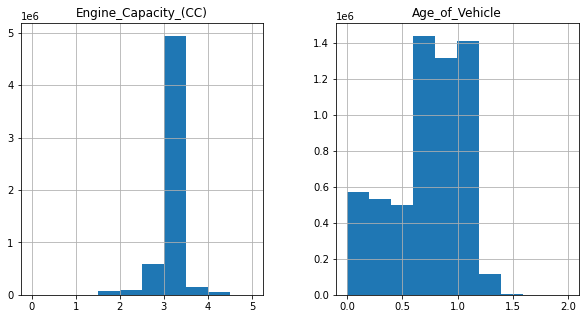

In [12]:
df_imbalanced.hist(figsize=(10,5));

#### *Handling with Outliers*

In [13]:
num_cols = ['Age_of_Vehicle', 'Engine_Capacity_(CC)']

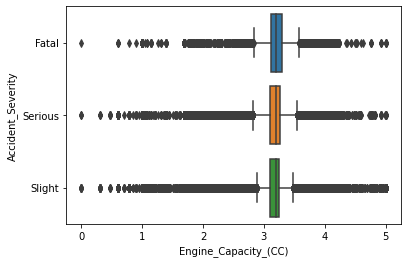

In [14]:
sns.boxplot(data=df_imbalanced,x='Engine_Capacity_(CC)',y='Accident_Severity')
plt.show()

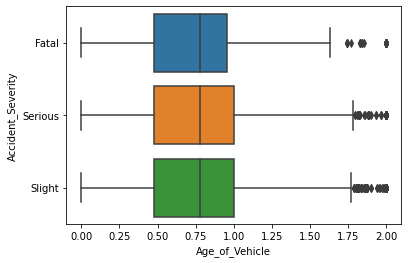

In [15]:
sns.boxplot(data=df_imbalanced,x='Age_of_Vehicle',y='Accident_Severity')
plt.show()

In [16]:
# As we can see there are some variables with outliers.
#Age_band_of_driver can be fixed. But the rest 
#(Engine capacity, vehicle type, Weather_Conditions_2 and Vehicle_Reference) have to be dropped.

for i in num_cols:
    Q1=df_imbalanced[i].quantile(0.25)
    Q3=df_imbalanced[i].quantile(0.75)
    IQR=Q3-Q1
    Lower_Whisker = Q1-1.5*IQR
    Upper_Whisker = Q3+1.5*IQR
    df_imbalanced = df_imbalanced[df_imbalanced[i] < Upper_Whisker]
    df_imbalanced = df_imbalanced[df_imbalanced[i] > Lower_Whisker]



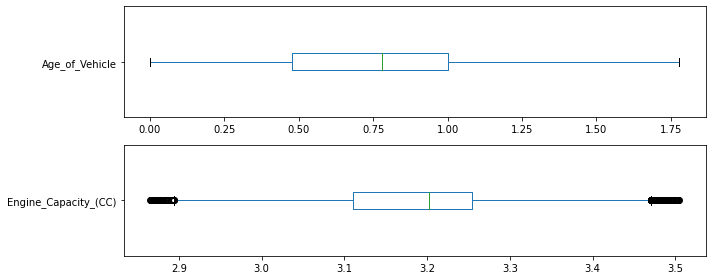

In [17]:
# plotting boxplots
fig, axes = plt.subplots(2,1, figsize=(10,4))

for ax, col in zip(axes, num_cols):
    df_imbalanced.boxplot(column=col, grid=False, vert=False, ax=ax)
    plt.tight_layout();

In [18]:
# We can see that the distribution of Engine capacity and age of vehicle improves a little.

### *Processing categorical variables*

In [19]:
# Converting the target variable into numeric categories
df_imbalanced['Accident_Severity'].replace({'Slight': 3, 'Serious': 2, 'Fatal': 1}, inplace=True)
df_imbalanced['Accident_Severity'] = df_imbalanced['Accident_Severity'].astype('int64')

In [20]:
cat,num = modules.vtypes(df_imbalanced)

In [21]:
#Labelencoder for categorical variables
def lencoder(df_imbalanced):
    lenc = LabelEncoder()
    df_imbalanced[cat] = df_imbalanced[cat].apply(lenc.fit_transform)
    df_imbalanced['Accident_Severity'] = lenc.fit_transform(df_imbalanced['Accident_Severity'])
    return df_imbalanced
df_imbalanced = lencoder(df_imbalanced)

In [22]:
df_imbalanced['Accident_Severity'].value_counts(normalize=True)

2    0.796402
1    0.177044
0    0.026554
Name: Accident_Severity, dtype: float64

In [23]:
df_imbalanced.head(5)

,Vehicle_Type,Sex_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Age_of_Vehicle,Accident_Severity,Day_of_Week,Speed_limit,Daytime,Road_Surface_Conditions_2,Weather_Conditions_2,Light_Conditions_2
4,8,1,5,3.000000,0.69897,2,5,13,4,1,1,1
5,2,1,4,3.105510,0.00000,2,3,13,3,1,1,0
7,2,1,3,3.103804,0.60206,2,2,13,3,0,0,0
8,2,1,4,3.203577,0.00000,2,2,13,3,0,0,0
9,2,1,2,3.161967,0.30103,2,2,13,3,0,0,0


#### *As we can see the dataset  is imbalanced. This is a real problem because the minority classes will report the worst score. So we are going to try with metrics like au_roc curve, f1score, recall and precision in order to check how good or bad is our model before apply techniques for handling imbalance data*.

In [24]:
df_imbalanced.to_csv('../../df_imbalanced.csv',sep=',',index = True)

In [25]:
reset -f